In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/secondary_data.csv', delimiter=';')
df.head(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
5,p,15.34,x,g,o,f,e,NaN,w,17.84,...,s,y,w,u,w,t,p,NaN,d,u
6,p,14.85,f,h,o,f,e,NaN,w,17.71,...,s,y,w,u,w,t,g,NaN,d,w
7,p,14.86,x,h,e,f,e,NaN,w,17.03,...,s,y,w,u,w,t,p,NaN,d,u
8,p,12.85,f,g,o,f,e,NaN,w,17.27,...,s,y,w,u,w,t,p,NaN,d,a
9,p,13.55,f,g,e,f,e,NaN,w,16.04,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
df.columns = df.columns.str.lower().str.replace('-', '_')

In [4]:
df.shape

(61069, 21)

In [5]:
df.dtypes

class                    object
cap_diameter            float64
cap_shape                object
cap_surface              object
cap_color                object
does_bruise_or_bleed     object
gill_attachment          object
gill_spacing             object
gill_color               object
stem_height             float64
stem_width              float64
stem_root                object
stem_surface             object
stem_color               object
veil_type                object
veil_color               object
has_ring                 object
ring_type                object
spore_print_color        object
habitat                  object
season                   object
dtype: object

In [6]:
numerical = df.select_dtypes(include=["float64"]).columns.tolist()
categorical = df.select_dtypes(include=["object"]).columns.tolist()
categorical.remove("class") # Remove target variable

#### Class Distribution

In [7]:
df["class"].value_counts(normalize=True)

class
p    0.554913
e    0.445087
Name: proportion, dtype: float64

#### Check for missing values

In [8]:
pd.DataFrame({
    'dtype': df.dtypes,
    'missing': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
})

,dtype,missing,missing_pct
class,object,0,0.00
cap_diameter,float64,0,0.00
cap_shape,object,0,0.00
cap_surface,object,14120,23.12
cap_color,object,0,0.00
does_bruise_or_bleed,object,0,0.00
gill_attachment,object,9884,16.18
gill_spacing,object,25063,41.04
gill_color,object,0,0.00
stem_height,float64,0,0.00


#### stem_root, veil_type, veil_color, spore_print_color have a major chunk of data missing. They are not going to be useful. I am going to remove them. I plan to treat missing values as a category of its own.

In [9]:
cols = ['stem_root', 'veil_type', 'veil_color', 'spore_print_color']
categorical = list(set(categorical) - set(cols))
df.drop(cols, inplace=True, axis=1)
df.fillna("unknown", inplace=True)

In [10]:
df[numerical].describe()

,cap_diameter,stem_height,stem_width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


#### Mean is greater than median for all the three variables which indicate skewness.

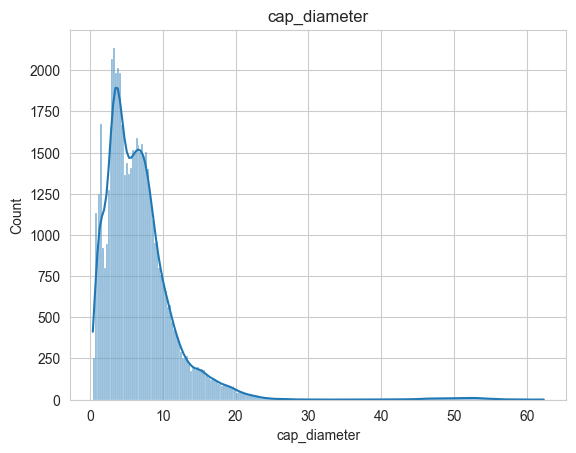

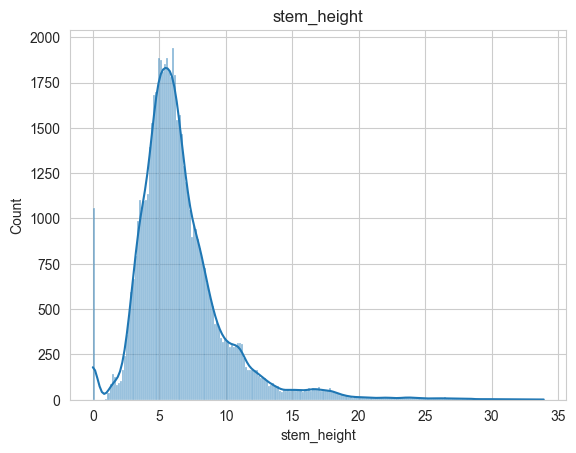

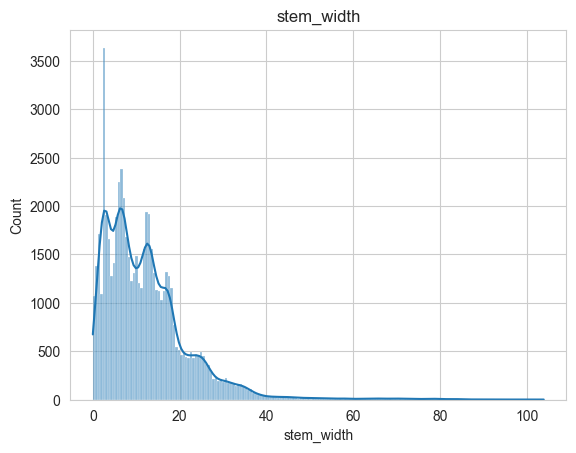

In [11]:
for c in numerical:
    sns.histplot(df[c], kde=True)
    plt.title(c)
    plt.show()


#### There is a long tail. Going to apply log transformation to handle the skewness.

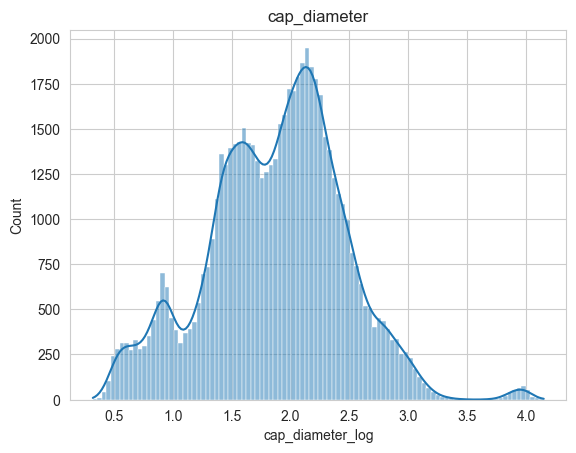

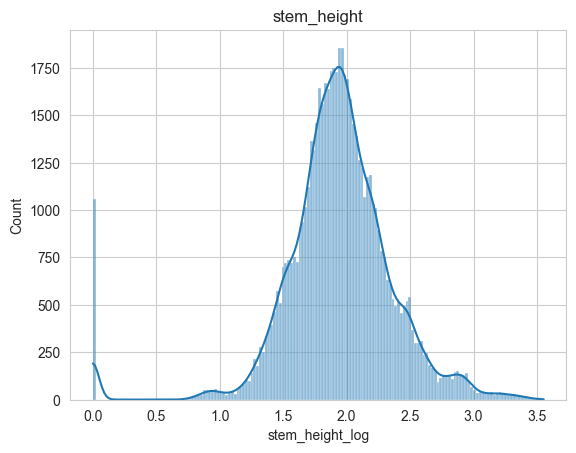

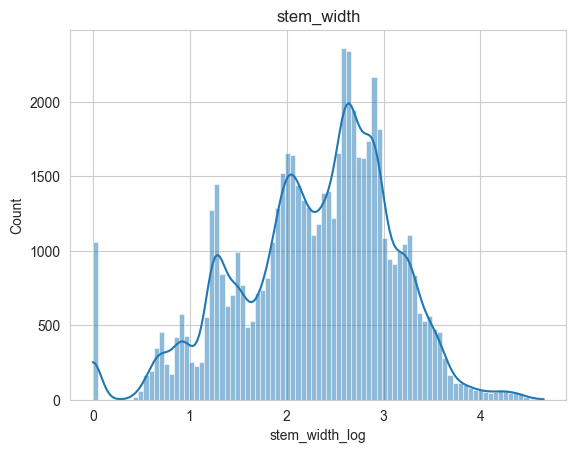

In [12]:
for col in numerical:
    df[col + '_log'] = np.log1p(df[col])

for c in numerical:
    sns.histplot(df[c + '_log'], kde=True)
    plt.title(c)
    plt.show()


#### stem_height now very much looks like a normal distribution. cap_diameter and stem_width looks a little bumpy. Maybe because different species of mushrooms comes in different sizes.

In [13]:
numerical_log = [col + '_log' for col in numerical]

In [14]:
df[numerical_log].corr()

,cap_diameter_log,stem_height_log,stem_width_log
cap_diameter_log,1.000000,0.467051,0.827303
stem_height_log,0.467051,1.000000,0.561462
stem_width_log,0.827303,0.561462,1.000000


#### cap_diameter and stem_width are highly correlated. Regularization should handle this.

#### Categorical variables

In [15]:
from sklearn.feature_selection import mutual_info_classif

X = df[categorical].apply(lambda col: col.astype('category').cat.codes)
mi = mutual_info_classif(X, df["class"])

mi_scores = sorted(zip(categorical, mi), key=lambda x: x[1], reverse=True)
mi_scores


[('stem_surface', np.float64(0.04778866978139784)),
 ('stem_color', np.float64(0.04381890294350366)),
 ('cap_color', np.float64(0.034520625976316)),
 ('ring_type', np.float64(0.03192904625080262)),
 ('cap_surface', np.float64(0.03014232627179192)),
 ('cap_shape', np.float64(0.025193369997608128)),
 ('gill_attachment', np.float64(0.02453100792341245)),
 ('habitat', np.float64(0.020925747649509496)),
 ('gill_color', np.float64(0.01840382682962316)),
 ('season', np.float64(0.011130232525137895)),
 ('gill_spacing', np.float64(0.009976449538824372)),
 ('does_bruise_or_bleed', np.float64(0.0025650892220736576)),
 ('has_ring', np.float64(0.0017321239757404072))]

#### Going to divide categorical variables into three categories based on mutual information score

In [16]:
high_cat = ['stem_color', 'stem_surface', 'cap_surface', 'ring_type', 'cap_color']
med_cat = ['gill_attachment', 'cap_shape', 'gill_color', 'habitat']
low_cat = ['season', 'has_ring', 'gill_spacing', 'does_bruise_or_bleed']

#### Logistic Regression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [18]:
def prepare_train(numerical_features, categorical_features):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numerical_features),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ]
    )

    log_reg = LogisticRegression(
    max_iter=1000,
    penalty="l2",        # default regularization (good with correlated features)
    solver="lbfgs",  # works for binary/multiclass
        random_state=42,
        C=10.0
)

    clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)
    return clf

def evaluation(X_test, y_test, clf):
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC AUC

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("ROC AUC:", roc_auc_score(y_test, y_proba))

#### With all features

In [19]:
numerical_features = numerical_log
categorical_features = categorical

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)

print("Train")
evaluation(X_train, y_train, clf)

print("Test")
evaluation(X_test, y_test, clf)

Train
Accuracy: 0.823620919046157
              precision    recall  f1-score   support

           e       0.79      0.82      0.81     21745
           p       0.85      0.83      0.84     27110

    accuracy                           0.82     48855
   macro avg       0.82      0.82      0.82     48855
weighted avg       0.82      0.82      0.82     48855

ROC AUC: 0.8906773380703993
Test
Accuracy: 0.8241362371049615
              precision    recall  f1-score   support

           e       0.79      0.82      0.80      5436
           p       0.85      0.83      0.84      6778

    accuracy                           0.82     12214
   macro avg       0.82      0.82      0.82     12214
weighted avg       0.82      0.82      0.82     12214

ROC AUC: 0.8897218330264278


#### With high mutial information score features

In [20]:
numerical_features = numerical_log
categorical_features = high_cat

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)

print("Train")
evaluation(X_train, y_train, clf)

print("Test")
evaluation(X_test, y_test, clf)

Train
Accuracy: 0.7767270494319927
              precision    recall  f1-score   support

           e       0.73      0.78      0.76     21745
           p       0.81      0.77      0.79     27110

    accuracy                           0.78     48855
   macro avg       0.77      0.78      0.78     48855
weighted avg       0.78      0.78      0.78     48855

ROC AUC: 0.8329027893564275
Test
Accuracy: 0.77427542164729
              precision    recall  f1-score   support

           e       0.73      0.77      0.75      5436
           p       0.81      0.78      0.79      6778

    accuracy                           0.77     12214
   macro avg       0.77      0.77      0.77     12214
weighted avg       0.78      0.77      0.77     12214

ROC AUC: 0.8286063957082289


#### With High and Medium mutual information score features

In [21]:
numerical_features = numerical_log
categorical_features = high_cat + med_cat

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)

print("Train")
evaluation(X_train, y_train, clf)

print("Test")
evaluation(X_test, y_test, clf)

Train
Accuracy: 0.8057312455224644
              precision    recall  f1-score   support

           e       0.77      0.80      0.79     21745
           p       0.83      0.81      0.82     27110

    accuracy                           0.81     48855
   macro avg       0.80      0.81      0.80     48855
weighted avg       0.81      0.81      0.81     48855

ROC AUC: 0.8763741394397472
Test
Accuracy: 0.806533486163419
              precision    recall  f1-score   support

           e       0.78      0.80      0.79      5436
           p       0.83      0.82      0.82      6778

    accuracy                           0.81     12214
   macro avg       0.80      0.81      0.80     12214
weighted avg       0.81      0.81      0.81     12214

ROC AUC: 0.8760772092805121


#### Fine tune parameters and apply k fold cross validation

In [22]:
from sklearn.model_selection import GridSearchCV

X = df[numerical_log + categorical]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_log, categorical)

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,                # 5-fold stratified
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'model__C': 10.0, 'model__class_weight': None}


In [23]:
results = pd.DataFrame(grid.cv_results_)

results[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score").head(10)

,params,mean_test_score,std_test_score,rank_test_score
6,"{'model__C': 10.0, 'model__class_weight': None}",0.889589,0.003067,1
4,"{'model__C': 1.0, 'model__class_weight': None}",0.889416,0.003103,2
7,"{'model__C': 10.0, 'model__class_weight': 'bal...",0.888983,0.003121,3
5,"{'model__C': 1.0, 'model__class_weight': 'bala...",0.888734,0.003286,4
2,"{'model__C': 0.1, 'model__class_weight': None}",0.886492,0.003824,5
3,"{'model__C': 0.1, 'model__class_weight': 'bala...",0.886050,0.003993,6
0,"{'model__C': 0.01, 'model__class_weight': None}",0.870166,0.005093,7
1,"{'model__C': 0.01, 'model__class_weight': 'bal...",0.869990,0.005288,8


#### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
def prepare_train(numerical_features, categorical_features):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numerical_features),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ]
    )

    model = DecisionTreeClassifier(random_state=42)

    clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model),
    ]
)
    return clf

In [26]:
X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)

print("Train")
evaluation(X_train, y_train, clf)

print("Test")
evaluation(X_test, y_test, clf)

Train
Accuracy: 1.0
              precision    recall  f1-score   support

           e       1.00      1.00      1.00     21745
           p       1.00      1.00      1.00     27110

    accuracy                           1.00     48855
   macro avg       1.00      1.00      1.00     48855
weighted avg       1.00      1.00      1.00     48855

ROC AUC: 1.0
Test
Accuracy: 0.9990993941378745
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      5436
           p       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC AUC: 0.9990428606075449


#### I think I found my model. Hehe.